In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import ast
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns

Using the Food.com dataset, we want to predict the rating a user will give a certain recipe. The goal is to predict the rating a user will give a recipe in hopes to predict how much the user will like the recipe. We will predict the rating using a range of models.

Our first baseline model will use the global average rating and use that as a prediction. Next we will use linear regression to create a prediction based on the recipe metadata

Next we will use a User-Item Bias model then modify that to include recipe similarity.

Finally using the preprocessed dataset, we will use a neural net to predict a rating.

**Load the Dataset as a pandas dataframe**

In [2]:
recipes_dataset = pd.read_csv('./Data/RAW_recipes.csv')

Tags are stored as a list but because CSV files are comma separated, the list but be a **string** in order to not to conflict with other values. We want to convert that into a **list**. (Example 'Tag' = "[American, sweet, desert, chocolate]")
   
Steps, Ingredients, and Nutritional Information are stored the same as tags so we also want to convert them into **lists**

Calories are always the first element in the nutritional information list, therefore make a column that contains only caloric information.


In [3]:
recipes_dataset['tags'] = recipes_dataset['tags'].apply(ast.literal_eval)
recipes_dataset['steps'] = recipes_dataset['steps'].apply(ast.literal_eval)
recipes_dataset['ingredients'] = recipes_dataset['ingredients'].apply(ast.literal_eval)
recipes_dataset['nutrition'] = recipes_dataset['nutrition'].apply(ast.literal_eval)
recipes_dataset['calories'] = recipes_dataset['nutrition'].apply(lambda x: x[0])



Iterate through the dataframe and add each recipe to the **recipes dictionary**. This dictionary will hold all recipes and have the recipe id as the key

In [4]:
recipes = {}

for index, row in recipes_dataset.iterrows():
    recipes[row['id']] = {
        'name' : row['name'],
        'id' : row['id'],
        'minutes' : int(row['minutes']),
        'contributor_id' : row['contributor_id'],
        'submitted' : pd.to_datetime(row['submitted']),
        'tags' : set(row['tags']),
        'nutrition' : row['nutrition'],
        'n_steps' : int(row['n_steps']),
        'steps' : set(row['steps']),
        'description' : row['description'],
        'ingredients' : set(row['ingredients']),
        'n_ingredients' : int(row['n_ingredients']),
        'calories' : int(row['calories']) 
    }



Load all the reviews into a dataframe

In [5]:
interactions = pd.read_csv('./Data/RAW_interactions.csv')

Convert the dates to usable dates using pandas

In [6]:
interactions['date'] = pd.to_datetime(interactions['date'])

We plot the ratings to see what the most common ratings are. After plotting, we can see that the most common rating is 5 stars. This overwhelmingly skews the rating to be positive. Also, a little over a quarter of all recipes have not been reviewed while the most popular recipes have been reviewed dozens or even hundreds of times. Finally this data is comprised of over 200,000 users yet almost 75 percent of them have not written a review. So although we have many users, most of them are not vocal which means our actual sample size of users is significantly smaller.

/var/folders/01/p0l2lhmx08g00y03cpyvxv500000gn/T/ipykernel_34476/3539006916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=interactions, palette='viridis')


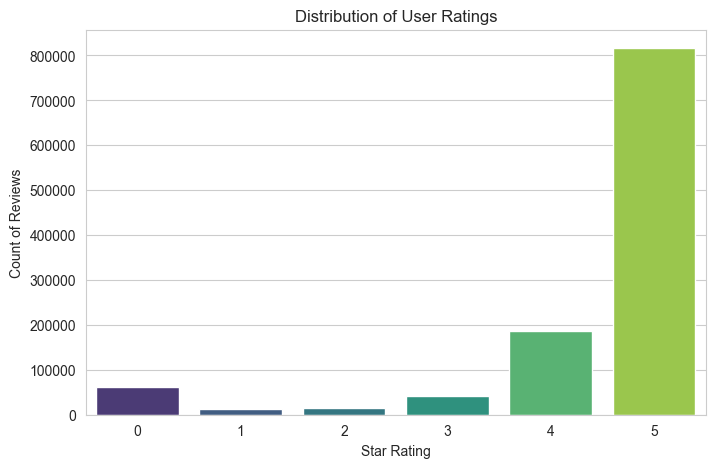

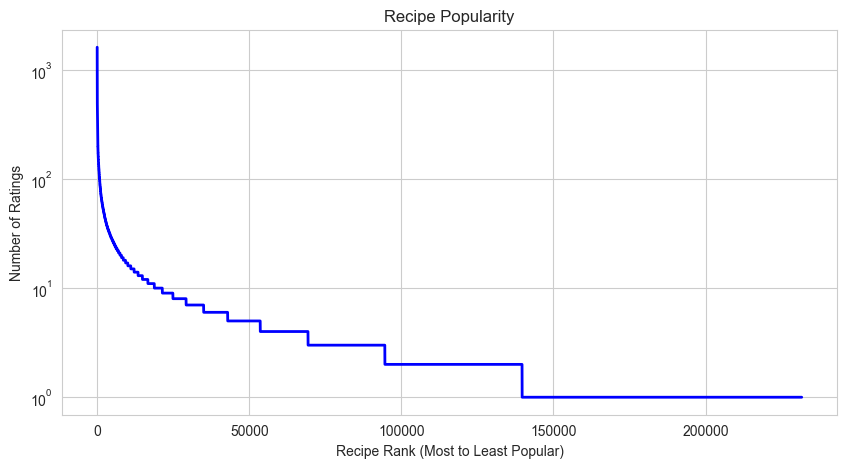

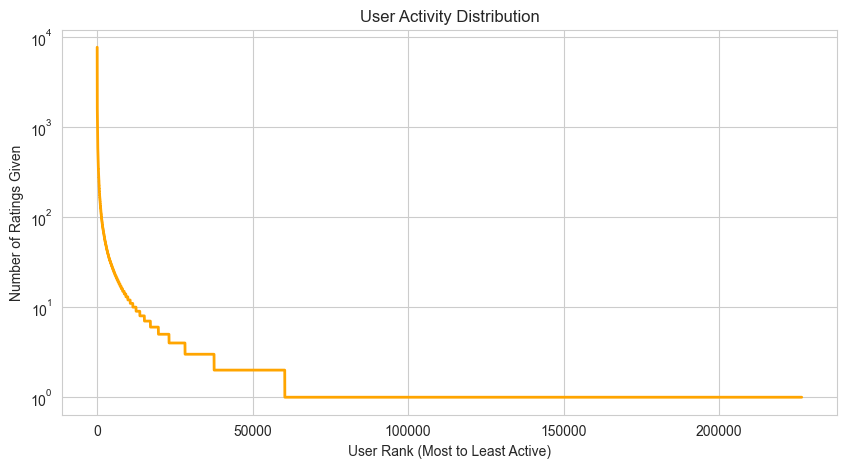

In [7]:
# Set the visual style
sns.set_style("whitegrid")

# Distribution of Ratings
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=interactions, palette='viridis')
plt.title('Distribution of User Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count of Reviews')
plt.show()

# How many ratings to recipes get
recipe_counts = interactions['recipe_id'].value_counts().values
plt.figure(figsize=(10, 5))
plt.plot(range(len(recipe_counts)), recipe_counts, color='blue', linewidth=2)
plt.yscale('log')  
plt.title('Recipe Popularity')
plt.xlabel('Recipe Rank (Most to Least Popular)')
plt.ylabel('Number of Ratings')
plt.show()

# User Activity
user_counts = interactions['user_id'].value_counts().values
plt.figure(figsize=(10, 5))
plt.plot(range(len(user_counts)), user_counts, color='orange', linewidth=2)
plt.yscale('log')
plt.title('User Activity Distribution')
plt.xlabel('User Rank (Most to Least Active)')
plt.ylabel('Number of Ratings Given')
plt.show()

In [8]:
def jaccard(s1,s2):
    numer = len(s1.intersection(s2))
    denom = len(s2.union(s1))
    return numer / denom if denom > 0 else 0

In [9]:
ratings = []

Create a list of tuples of user, item, and ratings to a list.

In [10]:
for index, row in interactions.iterrows():
    user, item, rating = row['user_id'], row['recipe_id'], row['rating']
    ratings.append((user,item,rating))

Shuffle the ratings then create two sets. One will be used to train the data, the other will be used to check its accuracy.

In [11]:
random.shuffle(ratings)
number_of_ratingss = len(ratings)
split = int(0.8 * number_of_ratingss)


In [12]:
training_data = ratings[:split]
validation_data = ratings[split:]



Fit a linear regression model to predict the rating. This model will use the number of minutes a recipe takes, the number of steps it has, the number of calories it has, and the number of ingredients. We do this because we assume that people tend to like recipes that are simple and easy to make or maybe healthy and low calorie, therefore personalizing with ingredients or tags wont be necessary.

In [13]:
def recipeVector(recipe):
    return [recipe.get('minutes',0), recipe.get('n_steps',0),recipe.get('calories',0), recipe.get('n_ingredients',0)]

In [14]:
X_train = []
y_train = []

for u, i, r in training_data:
    if i in recipes:
        X_train.append(recipeVector(recipes[i]))
        y_train.append(r)

X_valid = []
y_valid = []

for u, i, r in validation_data:
    if i in recipes:
        X_valid.append(recipeVector(recipes[i]))
        y_valid.append(r)

model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

predictions = model.predict(np.array(X_valid))
mse = np.mean((np.array(y_valid) - predictions) ** 2)

print(f"Linear Regression MSE: {mse}")

Linear Regression MSE: 1.6049790462619784


Create dictionaries of each rating a user has given an item and each rating a recipe has received from each user

In [15]:
reviews_per_user = defaultdict(list)
reviews_per_item = defaultdict(list)
for user, item, rating in training_data:
    reviews_per_user[user].append((item, rating))
    reviews_per_item[item].append((user, rating))

Calculate the mean rating of all ratings in the training set and get the MSE using the global average as a baseline

In [16]:
global_avg_rating = np.mean([r for _, _, r in training_data])
print(global_avg_rating)

4.411795874347191


In [17]:
global_avg_mse = 0.0
for u, i, r in validation_data:
    global_avg_mse += (r - global_avg_rating) ** 2
global_avg_mse /= len(validation_data)

print(f"Global Average Baseline MSE: {global_avg_mse}")

Global Average Baseline MSE: 1.6059448798100102


In [18]:
def alphaUpdate(ratingsTrain, alpha, betaU, betaI, lamb):
    newAlpha = 0
    for u,b,r in ratingsTrain:
        newAlpha += r - (betaU[u] + betaI[b])
    return newAlpha / len(ratingsTrain)

In [19]:
def betaUUpdate(ratingsPerUser, alpha, betaU, betaI, lamb):
    newBetaU = {}
    for u in ratingsPerUser:
        newBeta = 0
        for b,r in ratingsPerUser[u]:
            newBeta += r - (alpha + betaI[b])
        newBetaU[u] = newBeta / (lamb + len(ratingsPerUser[u]))
    return newBetaU

In [20]:
def betaIUpdate(ratingsPerItem, alpha, betaU, betaI, lamb):
    newBetaI = {}
    for b in ratingsPerItem:
        newBeta = 0
        for u,r in ratingsPerItem[b]:
            newBeta += r - (alpha + betaU[u])
        newBetaI[b] = newBeta / (lamb + len(ratingsPerItem[b]))
    return newBetaI

In [21]:
def userBiasModel(ratingsTrain, ratingsPerUser, ratingsPerItem, alpha, betaU, betaI,lamb):
    for i in range(10):
        alpha = alphaUpdate(ratingsTrain, alpha, betaU, betaI, lamb)
        betaU = betaUUpdate(ratingsPerUser, alpha, betaU, betaI, lamb)
        betaI = betaIUpdate(ratingsPerItem, alpha, betaU, betaI, lamb)
    return alpha, betaU, betaI

In [22]:
def getMSE(alpha,betaI,betaU, dataset):
    sse = 0
    for user, item, rating in dataset:
        prediction = alpha + betaU.get(user, 0.0) + betaI.get(item, 0.0)
        sse += (rating - prediction) ** 2
    mse = sse / len(dataset)
    return mse

In [23]:
user_review_history = defaultdict(list)

interactions.sort_values(by=['user_id', 'date'], inplace=True)

current_history = defaultdict(list)

for index, row in interactions.iterrows():
    user_id = int(row['user_id'])
    review_text = str(row['review'])

    user_review_history[user_id] = " ".join(current_history[user_id])
    
    current_history[user_id].append(review_text)

Run a model that calculates the user's bias and use that for prediction. Find the best $\lambda$ to minimize MSE 

In [24]:
# 1. Initialize Parameters
alpha = global_avg_rating
betaU = {u: 0.0 for u in reviews_per_user}
betaI = {i: 0.0 for i in reviews_per_item}
lambs = [0.1,0.5,1.0,5.0,500.0]

bestMSE = 100.0
bestIndex = 0
for i in range(len(lambs)):
    # 2. Run Training
    lamb = lambs[i]
    alpha = global_avg_rating
    betaU = {u: 0.0 for u in reviews_per_user}
    betaI = {i: 0.0 for i in reviews_per_item}

    alpha, betaU, betaI = userBiasModel(training_data, reviews_per_user, reviews_per_item, alpha, betaU, betaI, lamb)
    # 3. Evaluate
    train_mse = getMSE(alpha, betaU, betaI, training_data)
    valid_mse = getMSE(alpha, betaU, betaI, validation_data)

    if bestMSE > valid_mse:
        bestMSE = valid_mse
        bestIndex = i

print(bestMSE)
print(lambs[bestIndex])

1.6116010703795356
500.0


We ran a User-Item Bias Model that would take the global average and add a bias term for the user and item. The user's bias be calculated using their previous reviews, so if they tend to rate highly then the recipe will have a higher rating and if they tend to rate poorly then the recipe will have a lower predicted rating. The item bias term would be calculated similarly using the ratings that the recipes have been given by all users in the training set. The MSE was actually worse than just guessing the global average. This is likely because only a very small number of users actually rate recipes therefore there is not a lot of data on the recipes and users to positively affect the MSE.

Our solution is to add a similarity score that will be taken by calculating the Jaccard similarity of the set of ingredients and tags. This similarity will be weighted to minimize the MSE on the validation set.

Create a dictionary: User ID -> Set of all ingredients they have used
We only want to keep ingredients from recipes with ratings > 4 that way we are not adding disliked ingredients, same for tags

In [25]:
user_ingredient_profiles = defaultdict(set)
user_tag_profiles = defaultdict(set)

for u, i, r in training_data:
    if r >= 4:
        if i in recipes:
            recipe_ingredients = recipes[i]['ingredients']
            user_ingredient_profiles[u].update(recipe_ingredients)
            recipe_tags = recipes[i]['tags']
            user_tag_profiles[u].update(recipe_tags)


Calculate the rating based off the user's bias and the similarity of the recipe's tags and ingredients to the user's tags and ingredients

In [26]:
def similarityBiasModel(u, i, alpha, betaU, betaI, weight1,weight2):
    bias_pred = alpha + betaU.get(u, 0.0) + betaI.get(i, 0.0)
    
    jaccard_ingredients = 0.0
    if u in user_ingredient_profiles and i in recipes:
        u_ingredients = user_ingredient_profiles[u]
        i_ingredients = recipes[i]['ingredients']
         
        jaccard_ingredients = jaccard(u_ingredients,i_ingredients)

    jaccard_tag = 0.0
    if u in user_tag_profiles and i in recipes:
        u_tags = user_tag_profiles[u]
        i_tags = recipes[i]['tags']

        jaccard_tag = jaccard(u_tags,i_tags) 
   
    return bias_pred + (weight1 * (jaccard_tag)) +( weight2 * (jaccard_ingredients))

Find the best weights of the ingredient and tag similarity scores

In [27]:
weights = [0.0,0.1,0.25,0.5,0.75,1.0]
best_hybrid_mse = float('inf')
best_weight = 0
best_weight2 = 0
best_pen = 0
for w in weights:
    for j in weights:
        sse = 0
        for u, i, r in validation_data:
            pred = similarityBiasModel(u, i, alpha, betaU, betaI, w,j)
            sse += (r - pred) ** 2
        
        mse = sse / len(validation_data)        
        if mse < best_hybrid_mse:
            best_hybrid_mse = mse
            best_weight = w
            best_weight2 = j

print(f"\nBest Hybrid MSE: {best_hybrid_mse} (at weight {best_weight},{best_weight2})")


Best Hybrid MSE: 1.540022275344563 (at weight 0.5,0.1)


This hybrid model achieved a better MSE than the global average, linear regression model, and the User-Item Bias Model. This shows that users tend to like similar recipes that either have similar recipes or similar tags.

Our final model will be a neural net. The dataset comes in two versions, a raw dataset and a preprocessed dataset. This model will be using the preprocessed dataset.

In [28]:
# 1. Load the Pre-Processed Data
pp_recipes = pd.read_csv('./Data/PP_recipes.csv')
pp_users = pd.read_csv('./Data/PP_users.csv')

# 2. Parse the list columns (Strings -> Lists)
# This converts "[1, 2, 3]" to the list [1, 2, 3]
pp_recipes['ingredient_ids'] = pp_recipes['ingredient_ids'].apply(ast.literal_eval)
pp_users['items'] = pp_users['items'].apply(ast.literal_eval)
pp_users['ratings'] = pp_users['ratings'].apply(ast.literal_eval)


# 3. Create Training Samples (Flattening the user history)
# Modify data to have one row per interaction (User, Item, Rating) for training.

interaction_list = []

for index, row in pp_users.iterrows():
    user_internal_id = row['u']
    item_list = row['items']
    rating_list = row['ratings']
    
    # Zip them together to get individual interactions
    for item_id, rating in zip(item_list, rating_list):
        interaction_list.append([user_internal_id, item_id, rating])

df_train = pd.DataFrame(interaction_list, columns=['u', 'i', 'rating'])

In [29]:
train_df, valid_df = train_test_split(df_train, test_size=0.2, random_state=42)

class FoodDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['u'].values, dtype=torch.long)
        self.items = torch.tensor(df['i'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

train_dataset = FoodDataset(train_df)
valid_dataset = FoodDataset(valid_df)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

In [30]:
class MatrixFactorizationNN(nn.Module):
    def __init__(self, num_users, num_items, n_factors=4):
        super(MatrixFactorizationNN, self).__init__()
        
        # User Embeddings (Gamma_u) & Bias (Beta_u)
        self.user_factors = nn.Embedding(num_users, n_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        
        # Item Embeddings (Gamma_i) & Bias (Beta_i)
        self.item_factors = nn.Embedding(num_items, n_factors)
        self.item_bias = nn.Embedding(num_items, 1)
        
        # Global Bias (Alpha)
        self.global_bias = nn.Parameter(torch.tensor(0.0))

    def forward(self, user, item):
        # 1. Get Embeddings
        u_factor = self.user_factors(user)
        i_factor = self.item_factors(item)
        
        # 2. Dot Product (Similarity)
        dot_product = (u_factor * i_factor).sum(dim=1, keepdim=True)
        
        # 3. Add Biases
        u_b = self.user_bias(user)
        i_b = self.item_bias(item)
        
        # Prediction = Alpha + Beta_u + Beta_i + (Gamma_u * Gamma_i)
        output = self.global_bias + u_b + i_b + dot_product
        
        return output.squeeze() # Remove extra dimension

In [31]:
num_users = df_train['u'].max() + 1
num_items = df_train['i'].max() + 1

model = MatrixFactorizationNN(num_users, num_items, n_factors=4)
criterion = nn.MSELoss() #
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
device = torch.device("cpu")
model.to(device)

for epoch in range(5):
    model.train()
    total_loss = 0
    
    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        
        # Forward pass
        predictions = model(users, items)
        loss = criterion(predictions, ratings)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    # Validation Step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for users, items, ratings in valid_loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            preds = model(users, items)
            v_loss = criterion(preds, ratings)
            val_loss += v_loss.item()
            
    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(valid_loader)
    
    print(f"Epoch {epoch+1}: Train MSE = {avg_train_loss:.4f}, Valid MSE = {avg_val_loss:.4f}")

Epoch 1: Train MSE = 1.8097, Valid MSE = 0.8494
Epoch 2: Train MSE = 0.8458, Valid MSE = 0.8483
Epoch 3: Train MSE = 0.8465, Valid MSE = 0.8473
Epoch 4: Train MSE = 0.8459, Valid MSE = 0.8487
Epoch 5: Train MSE = 0.8456, Valid MSE = 0.8465


Using the neural net we were able to significantly reduce the MSE of our dataset. This is likely because the neural net more data than the other models do individually. This allows the model to more accurately predict a rating of a given recipe.